# National Inventory of Dams

In [1]:
import geopandas as gpd

from pygeohydro import NID

In [2]:
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 300, "facecolor": "w"}
CRS = "esri:102008"

First, we need to instantiate the NID class.

In [3]:
nid = NID()

Some dam coordinates are either missing or incorrect. Let's get dams that are within Contiguous US with max storage larger than 200 acre-feet.

In [4]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geom = world[world.iso_a3 == "USA"].geometry.iloc[0].geoms[0]

dam_list = nid.get_byfilter([{"maxStorage": ["[200 5000]"]}])
conus_dams = dam_list[0][dam_list[0].is_valid]
conus_dams = conus_dams[conus_dams.within(conus_geom)]
conus_dams = nid.inventory_byid(conus_dams.id.to_list())

Next, we can get a count of the top 10 dams based on types.

In [5]:
dam_types = conus_dams.primaryDamTypeId.fillna(-1).astype(int)
conus_dams["primaryDamTypeName"] = dam_types.apply(nid.dam_type.get)

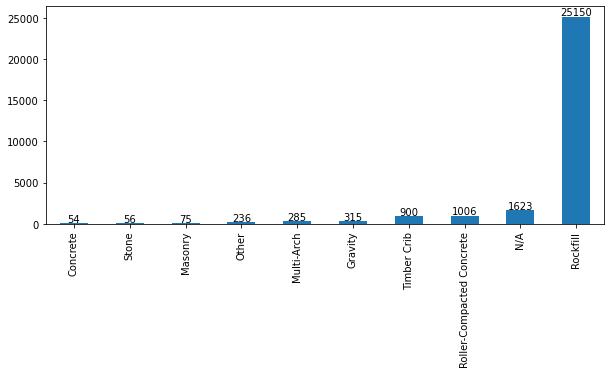

In [6]:
types_count = conus_dams["primaryDamTypeName"].value_counts()
ax = types_count.sort_values()[-10:].plot.bar(figsize=(10, 4))
for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height() + 500),
        ha="center",
        va="center",
    )

Let's compare the spatial distribution of the top five categories, excluding Earth and Other categories.

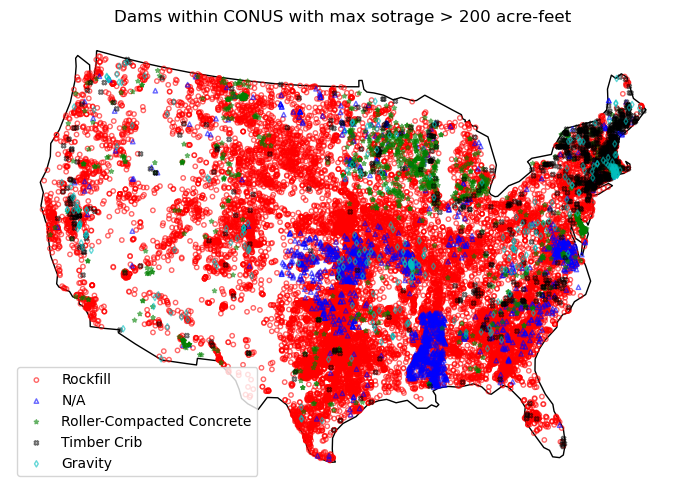

In [7]:
conus = gpd.GeoSeries([conus_geom], crs=world.crs).to_crs(CRS)
ax = conus.plot(figsize=(10, 6), facecolor="none", edgecolor="k")
top_5types = types_count.index[:5]
marker = dict(zip(top_5types, ["o", "^", "*", "X", "d"]))
color = dict(zip(top_5types, ["r", "b", "g", "k", "c"]))
conus_dams = conus_dams.to_crs(CRS)
for c in top_5types:
    conus_dams[conus_dams.primaryDamTypeName == c].plot(
        ax=ax,
        alpha=0.6,
        markersize=10,
        marker=marker[c],
        facecolor="none",
        color=color[c],
        label=c,
    )
ax.legend()
ax.axis(False)
ax.set_title("Dams within CONUS with max sotrage > 200 acre-feet")
ax.figure.set_dpi(100)
ax.figure.savefig("_static/dams.png", **SAVE_KWDS)